# Model Evaluation

Evaluate all wind speed prediction models using the evaluation framework.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from eval_helpers import evaluate, plot_predictions, compare
from data.data_helpers import get_dataframe
from models import (
    PersistenceModel,
    LinearRegressionModel,
    RandomForestModel,
    XGBoostModel,
    MLPModel,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load Data


In [2]:
# Load data
df = get_dataframe()
df = df.dropna(subset=["target_next_hour"])

# Temporal split: 2018-2019 for training, 2020 for testing
train_df = df[df["datetime"] < "2020-01-01"].copy()
test_df = df[df["datetime"] >= "2020-01-01"].copy()

print(f"Training set: {len(train_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

# Store datetime for plotting
test_datetime = test_df["datetime"].copy()


c:\Coding\Language\Python\VirtualEnvs\cis5200\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-12-06 19:31:29,744 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2018_H1.nc
Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2018_H2.nc
Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2019_H1.nc
Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2019_H2.nc
Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2020_H1.nc
Skipping existing file C:\Coding\Github-Repo\CIS-5200-Project\data\era5_tehachapi_2020_H2.nc
Training set: 17,520 samples
Test set: 8,783 samples


## Evaluate Models

Evaluate each model and collect results.



Training PersistenceBaseline model...


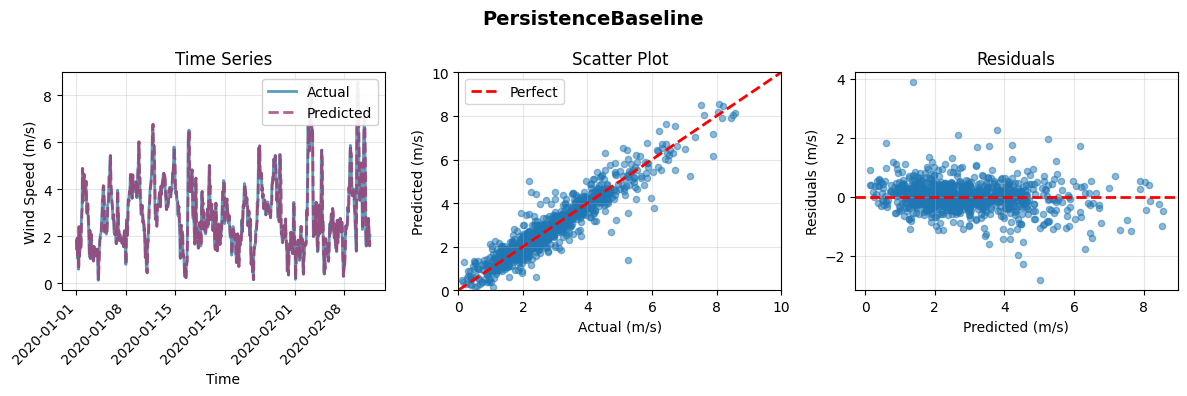


Training LinearRegression model...


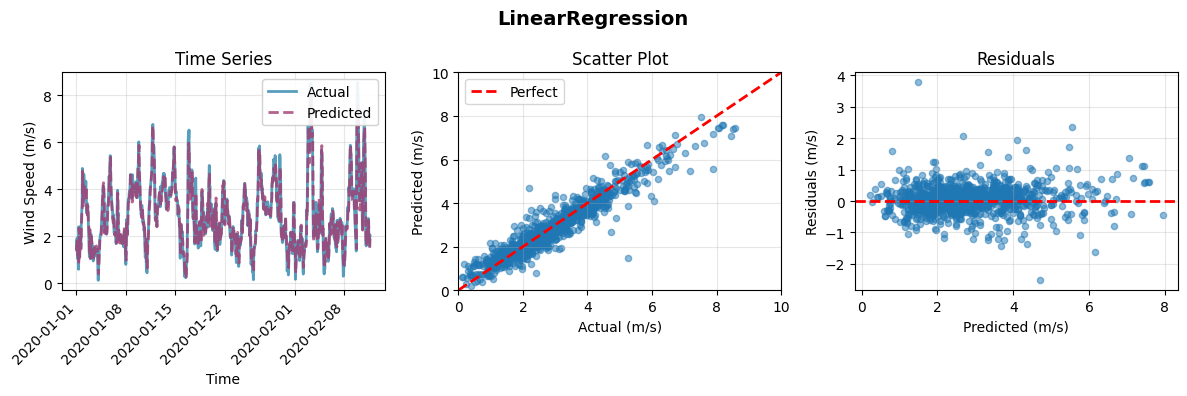


Training RandomForest model...


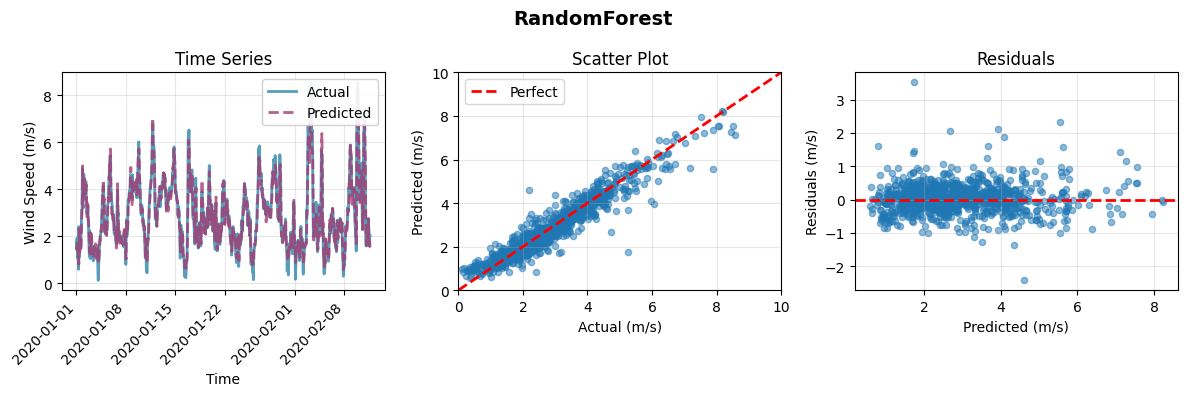


Training XGBoost model...


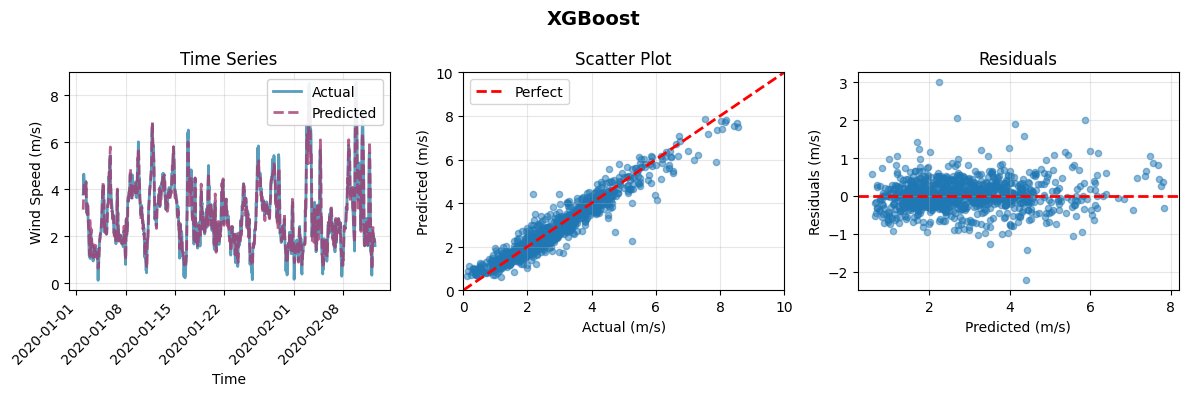


Training MLP model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

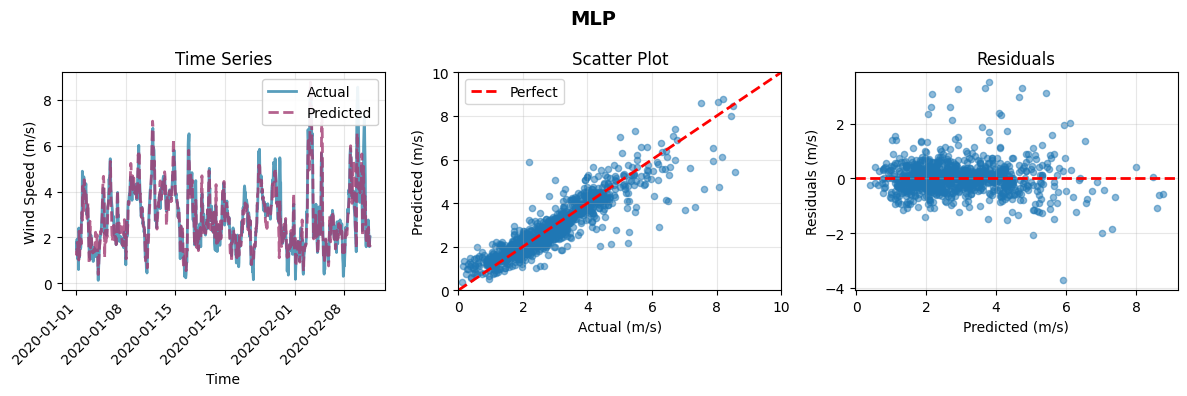

In [3]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [
    {'name': 'PersistenceBaseline', 'constructor': PersistenceModel, 'data_view': 'full'},
    {'name': 'LinearRegression', 'constructor': LinearRegressionModel, 'data_view': 'features'},
    {'name': 'RandomForest', 'constructor': RandomForestModel, 'data_view': 'features'},
    {'name': 'XGBoost', 'constructor': XGBoostModel, 'data_view': 'full', 'mask_nan_predictions': True},
    {'name': 'MLP', 'constructor': MLPModel, 'data_view': 'features'},
]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()


## Compare All Models



MODEL COMPARISON
              Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
            XGBoost   0.233156    0.332959 0.943337        0.168761
       RandomForest   0.251329    0.360330 0.933627        0.201054
   LinearRegression   0.280173    0.392446 0.921268        0.236544
                MLP   0.296412    0.437586 0.902114        0.288199
PersistenceBaseline   0.315406    0.452842 0.895170        0.308777


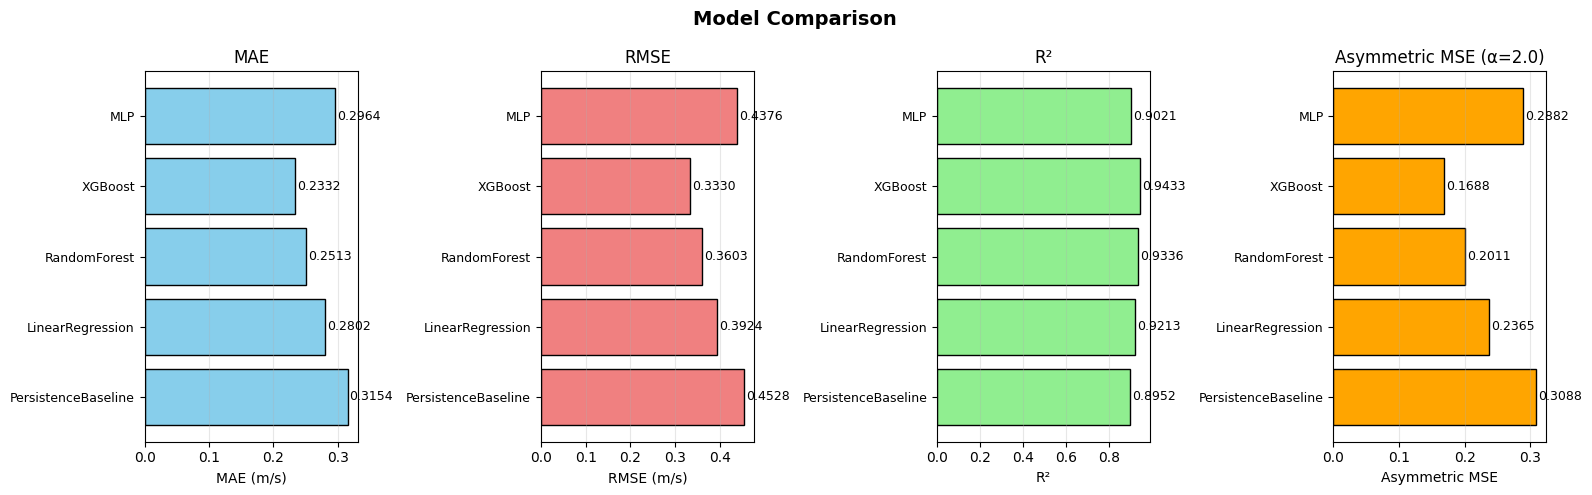

In [4]:
# Compare all models
scorecard = compare(results, plot=True)


MLP Comparison with different hidden layer sizes


Training MLP_200_100 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

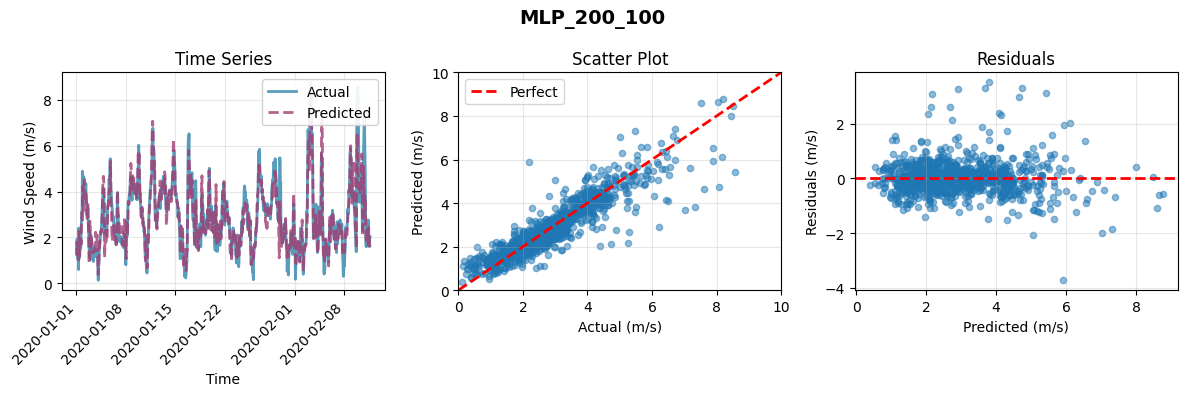


Training MLP_128_64 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

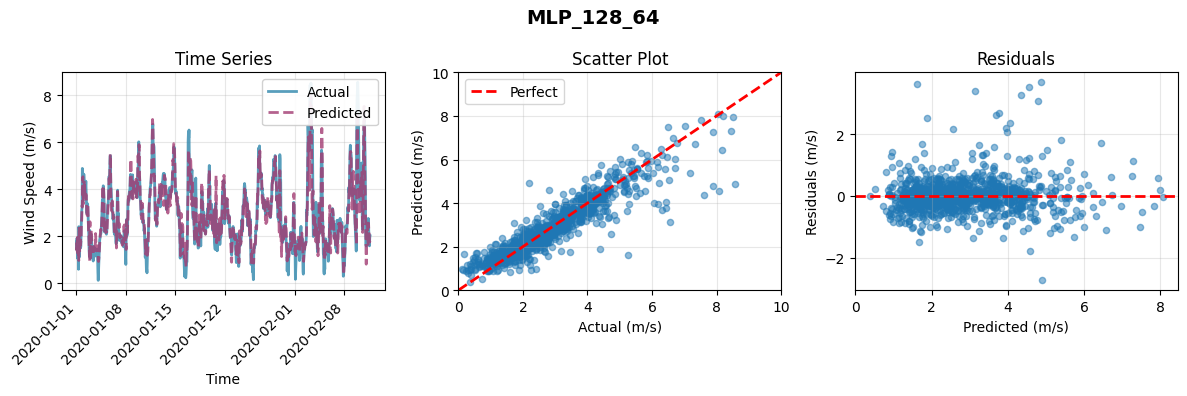


Training MLP_64_32 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

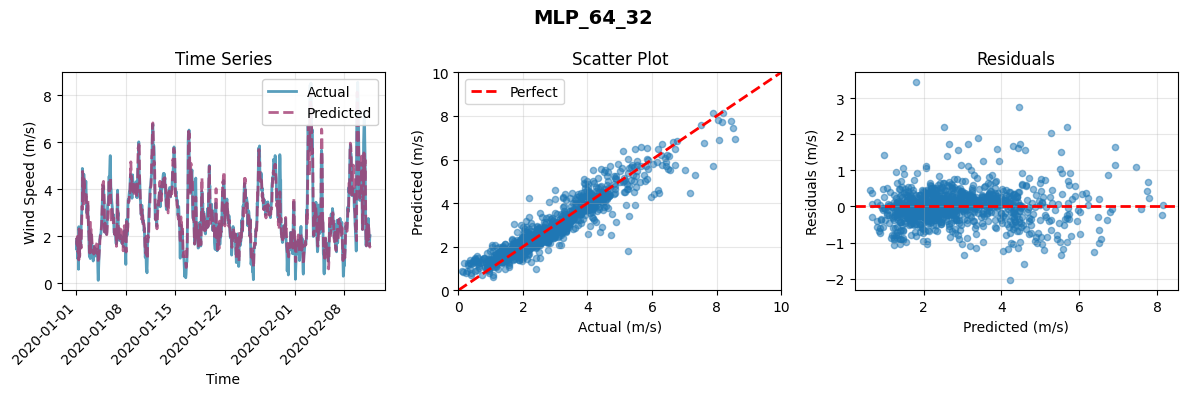


Training MLP_32_16 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

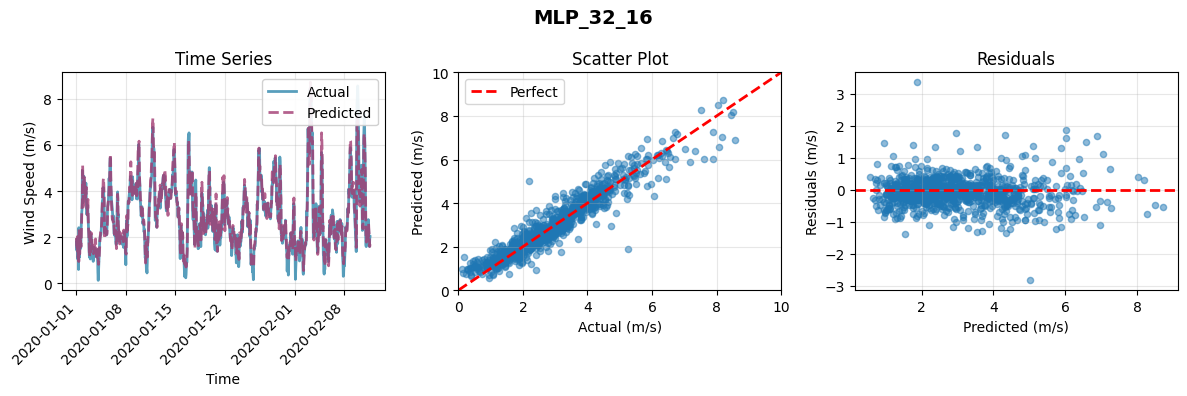


Training MLP_16_8 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

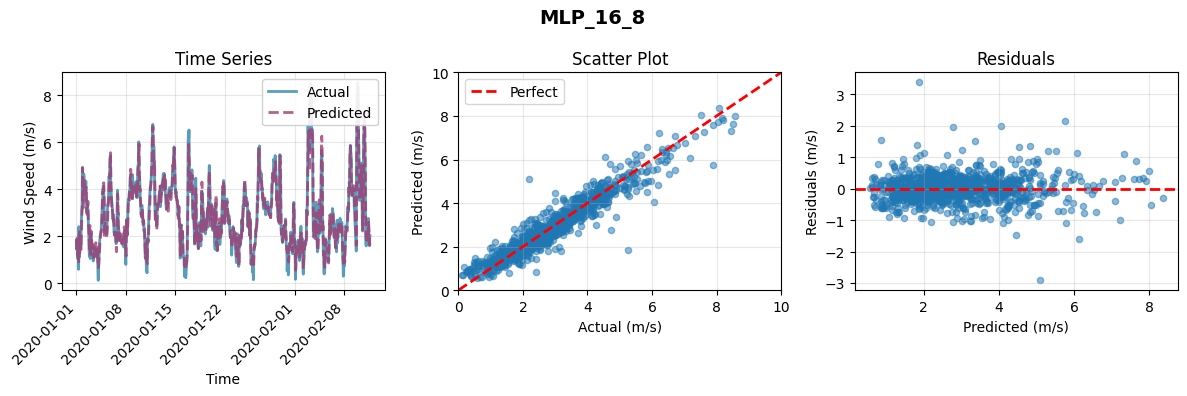


Training MLP_8_4 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

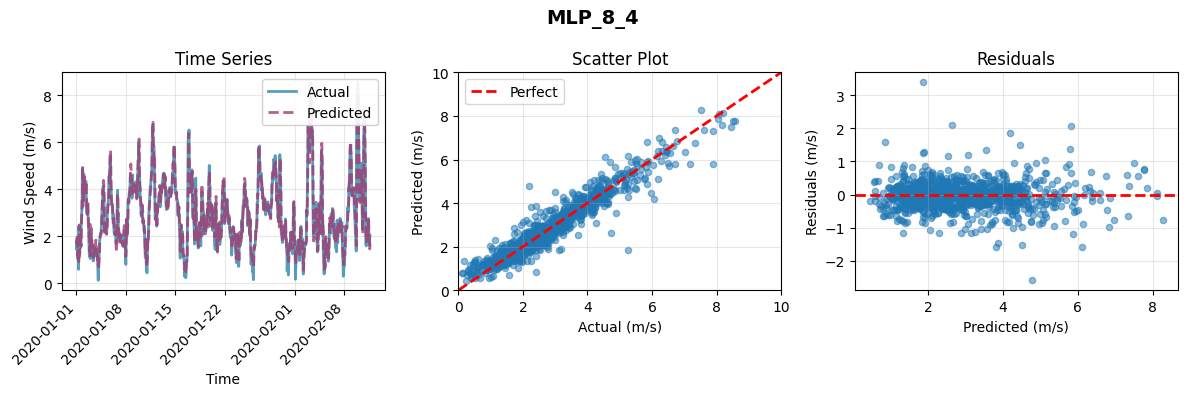


Training MLP_4_2 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

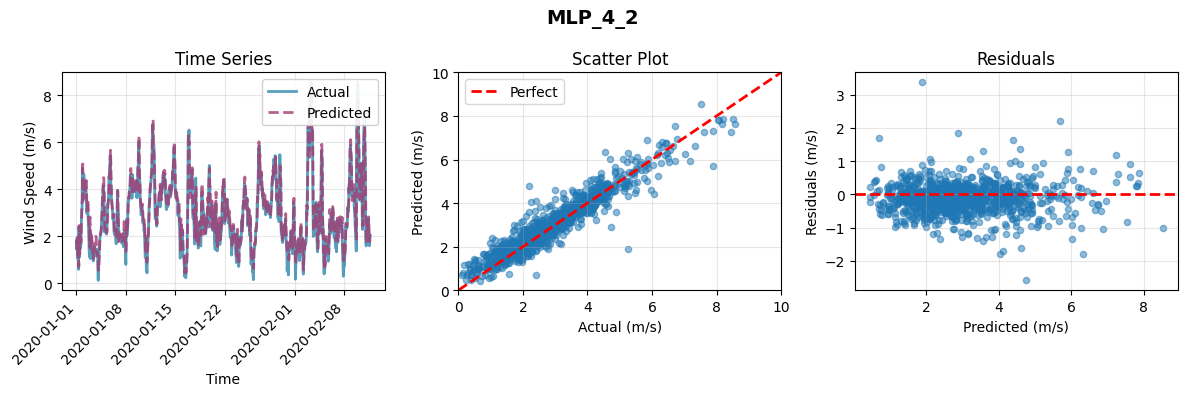


Training MLP_2_1 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

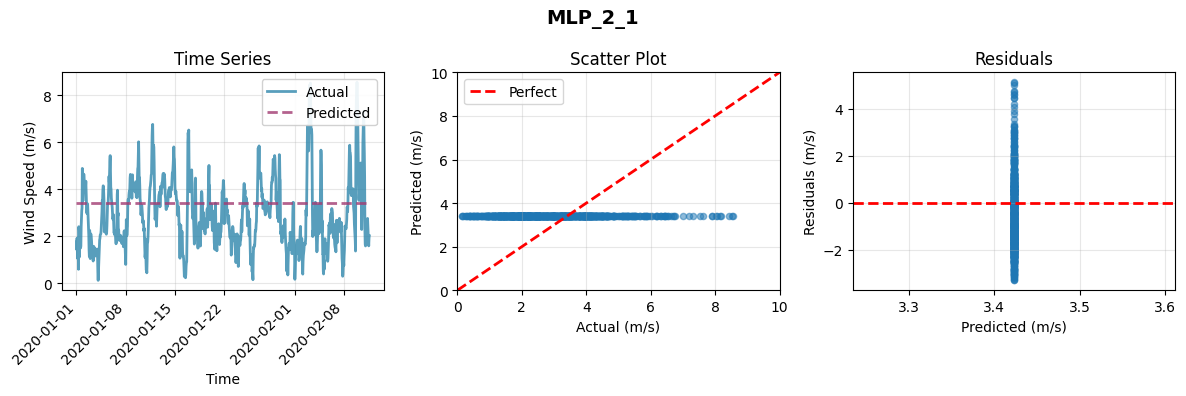


MODEL COMPARISON
      Model  MAE (m/s)  RMSE (m/s)        R²  Asymmetric MSE
  MLP_32_16   0.266261    0.367267  0.931046        0.172243
    MLP_8_4   0.255064    0.358352  0.934353        0.174268
   MLP_16_8   0.244411    0.346682  0.938560        0.175509
  MLP_64_32   0.265113    0.379440  0.926400        0.206092
    MLP_4_2   0.283733    0.395405  0.920076        0.206774
 MLP_128_64   0.284044    0.413085  0.912769        0.255923
MLP_200_100   0.296412    0.437586  0.902114        0.288199
    MLP_2_1   1.208595    1.464996 -0.097148        2.927248


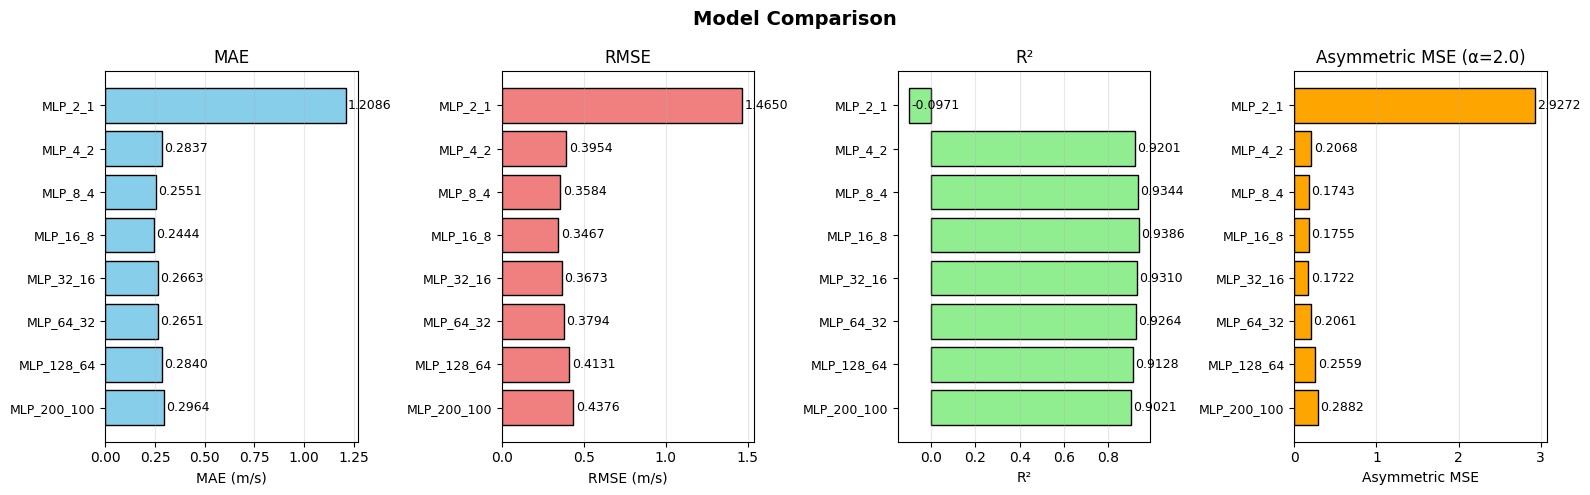

In [5]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [

    {'name': 'MLP_200_100', 'constructor': MLPModel, 'data_view': 'features', 'params': {'hidden_layer_sizes': [200, 100]}},

    {'name': 'MLP_128_64',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [128, 64]}},

    {'name': 'MLP_64_32',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [64, 32]}},

    {'name': 'MLP_32_16',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16]}},

    {'name': 'MLP_16_8',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [16, 8]}},

    {'name': 'MLP_8_4',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [8, 4]}},

    {'name': 'MLP_4_2',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [4, 2]}},

    {'name': 'MLP_2_1',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [2, 1]}},
]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()



    # Compare all models
scorecard = compare(results, plot=True)

Experimenting with different Network Depth


Training MLP_32_16 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

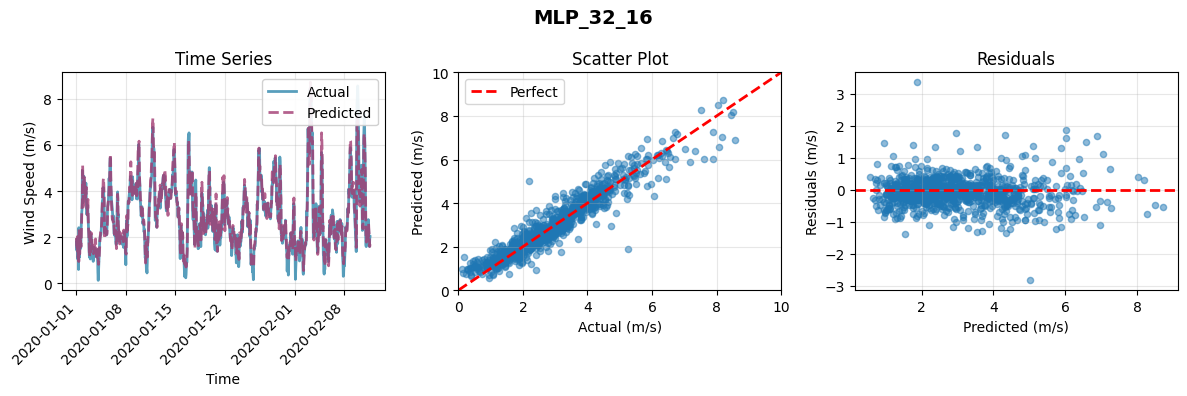


Training MLP_32_16_8 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

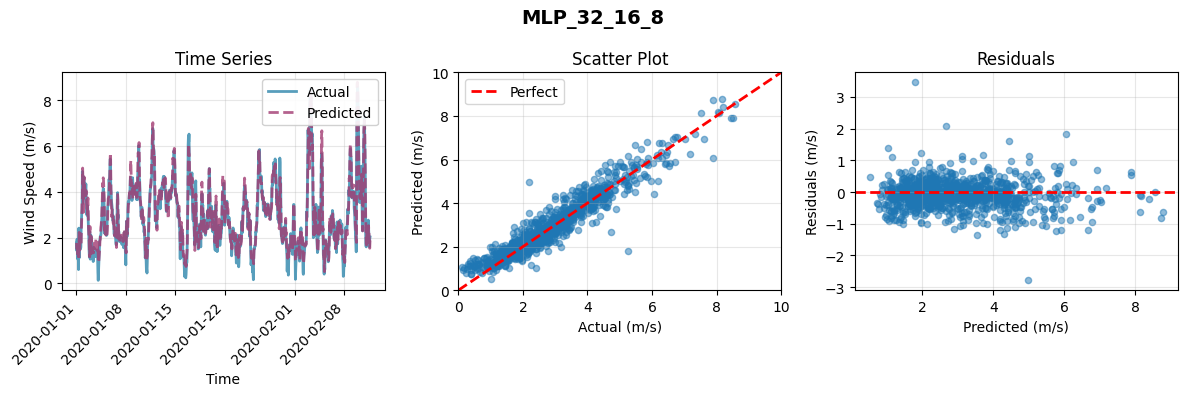


Training MLP_32_16_8_4 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

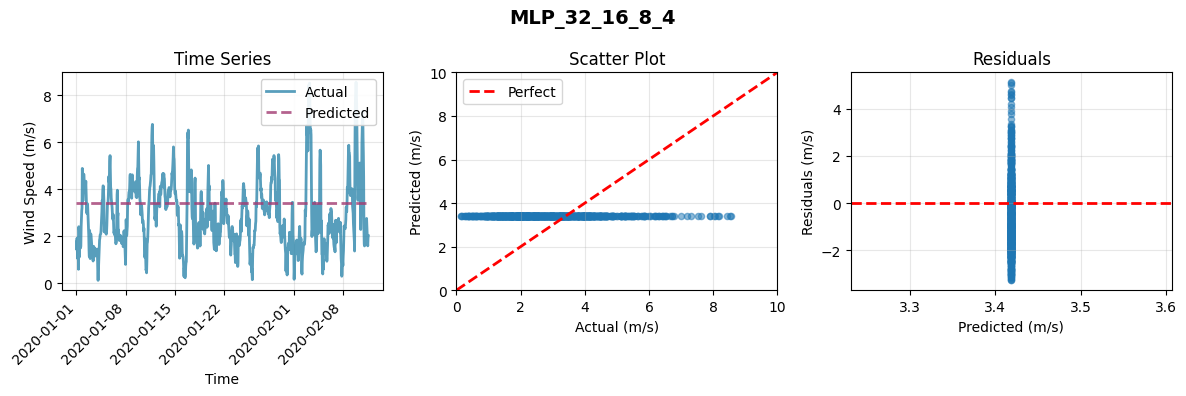


Training MLP_32_16_8_4_2 model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

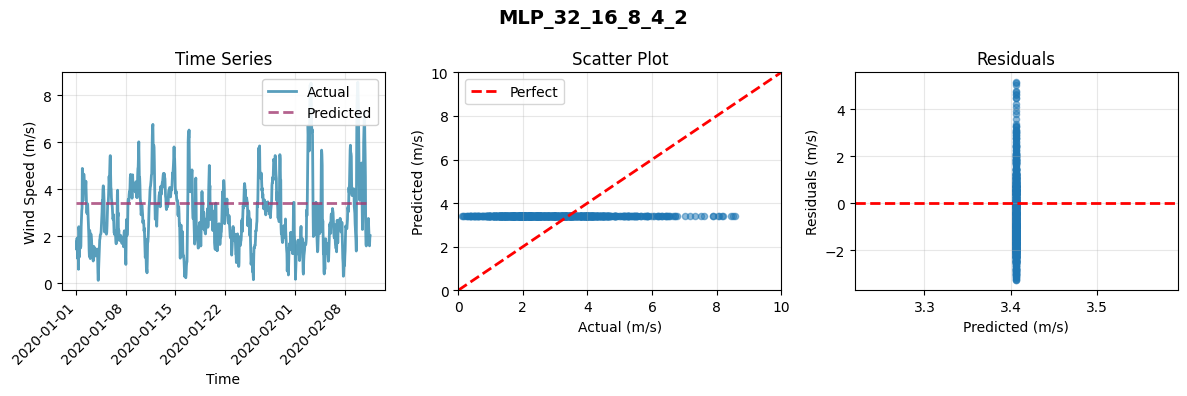


MODEL COMPARISON
          Model  MAE (m/s)  RMSE (m/s)        R²  Asymmetric MSE
      MLP_32_16   0.266261    0.367267  0.931046        0.172243
    MLP_32_16_8   0.262990    0.369049  0.930376        0.177091
MLP_32_16_8_4_2   1.202896    1.460112 -0.089845        2.925962
  MLP_32_16_8_4   1.207129    1.463735 -0.095260        2.926850


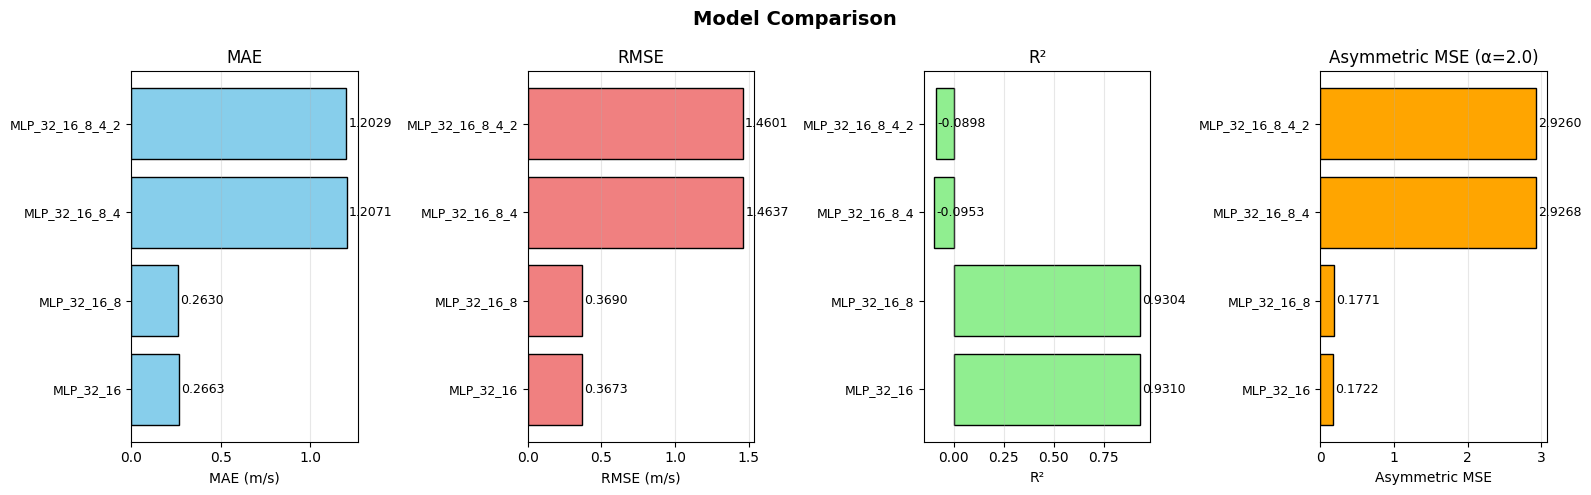

In [6]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [

    {'name': 'MLP_32_16',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16]}},

    {'name': 'MLP_32_16_8',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16, 8]}},

    {'name': 'MLP_32_16_8_4',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16, 8, 4]}},

    {'name': 'MLP_32_16_8_4_2',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16, 8, 4, 2]}},

]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()



    # Compare all models
scorecard = compare(results, plot=True)

Experimenting with different activation functions


Training MLP_32_16_leaky-relu model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

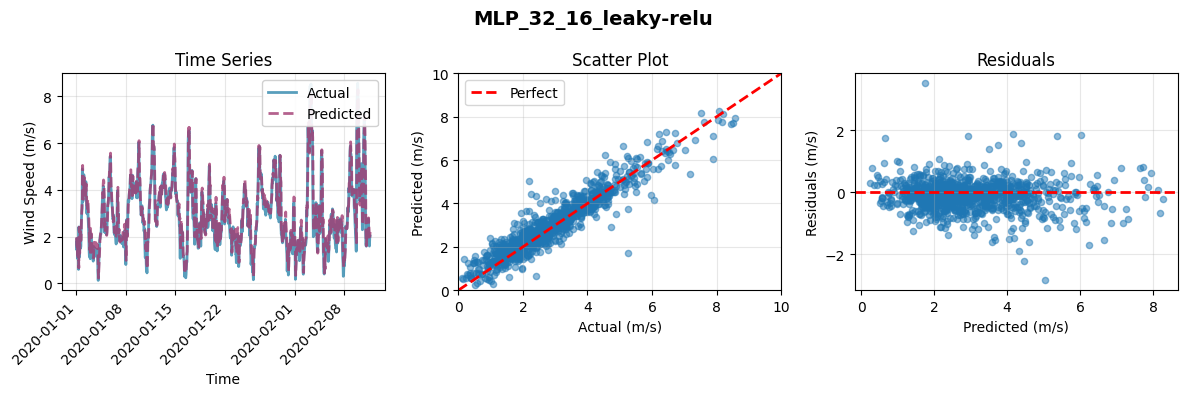


Training MLP_32_16_relu model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

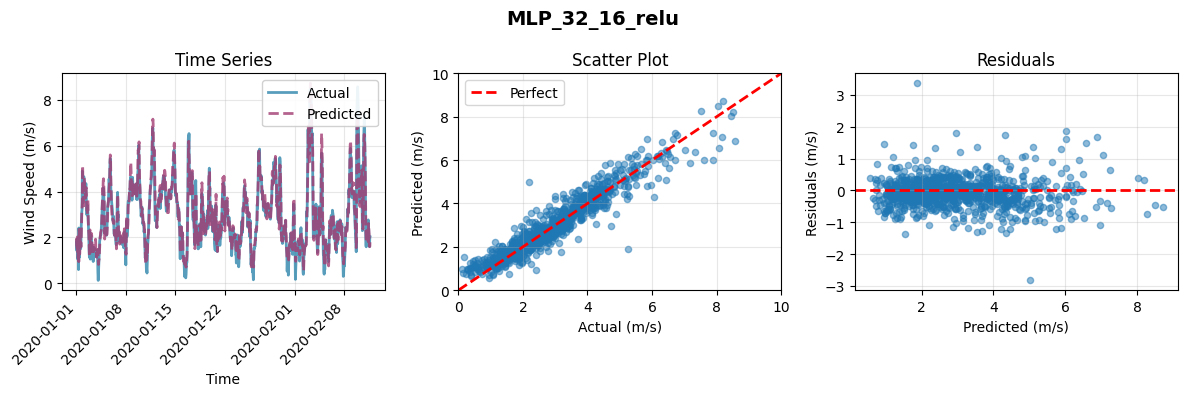


Training MLP_32_16_tanh model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

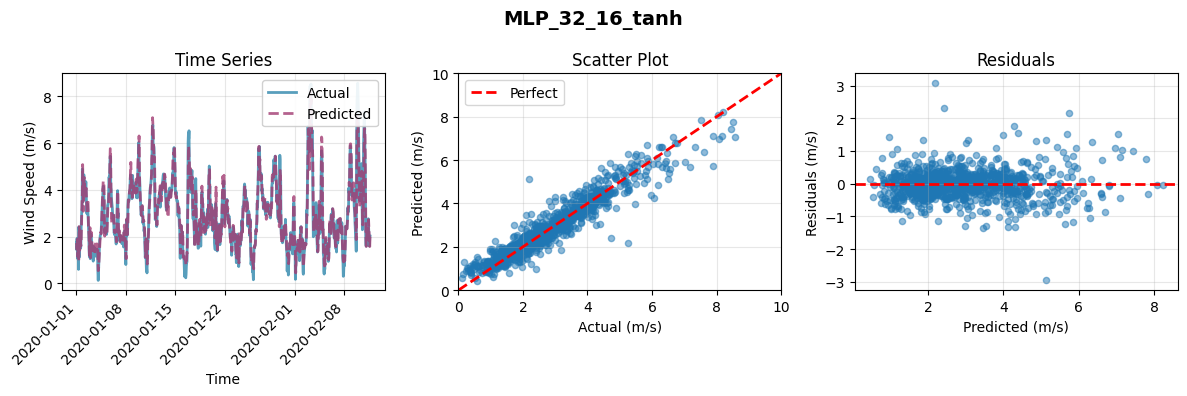


Training MLP_32_16_sigmoid model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

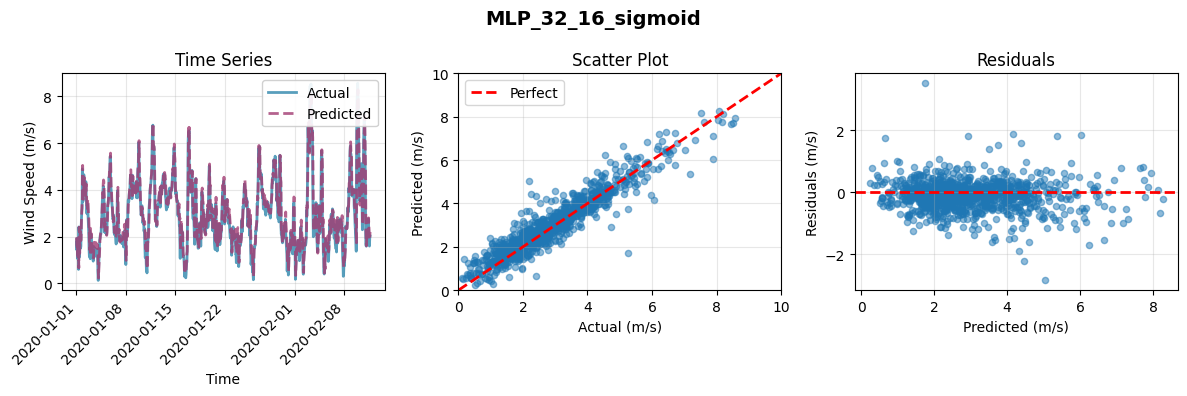


MODEL COMPARISON
               Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
      MLP_32_16_relu   0.266261    0.367267 0.931046        0.172243
      MLP_32_16_tanh   0.262005    0.366257 0.931425        0.175830
MLP_32_16_leaky-relu   0.321542    0.452352 0.895397        0.261016
   MLP_32_16_sigmoid   0.321542    0.452352 0.895397        0.261016


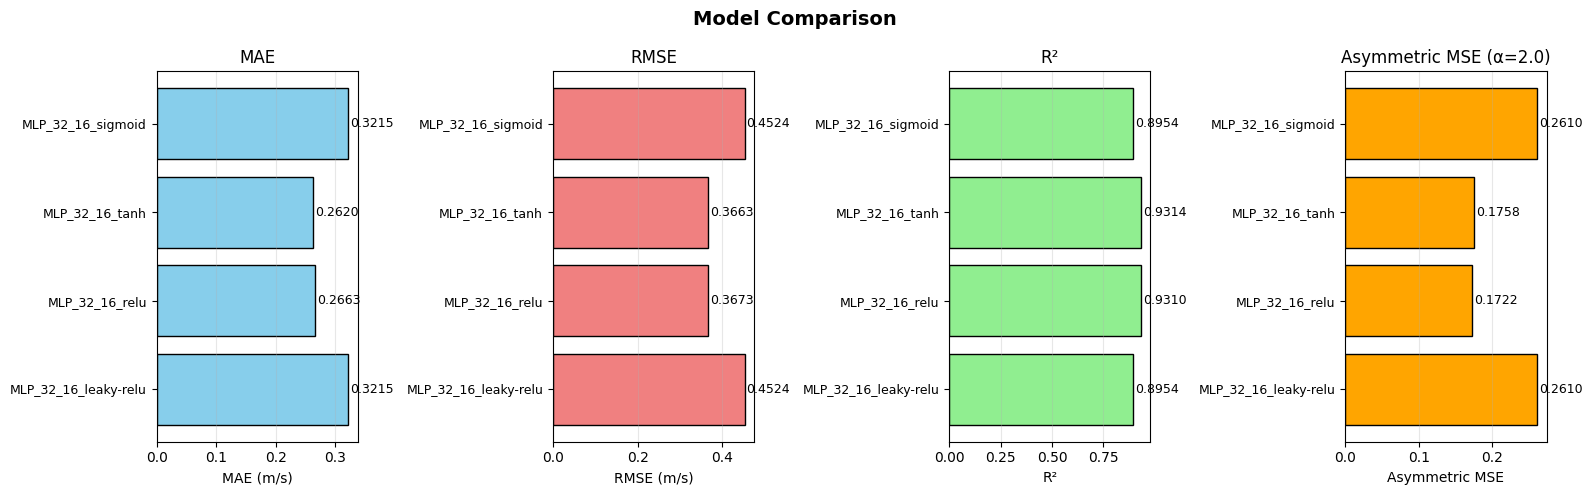

In [10]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [

    {'name': 'MLP_32_16_leaky-relu',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16], 'activation': "leaky_relu"}},

    {'name': 'MLP_32_16_relu',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16], 'activation': 'relu'}},

    {'name': 'MLP_32_16_tanh',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16], 'activation': "tanh"}},

    {'name': 'MLP_32_16_sigmoid',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [32, 16], 'activation': "sigmoid"}},

]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()



    # Compare all models
scorecard = compare(results, plot=True)

Also test on 8, 4


Training MLP_8_4_leaky-relu model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

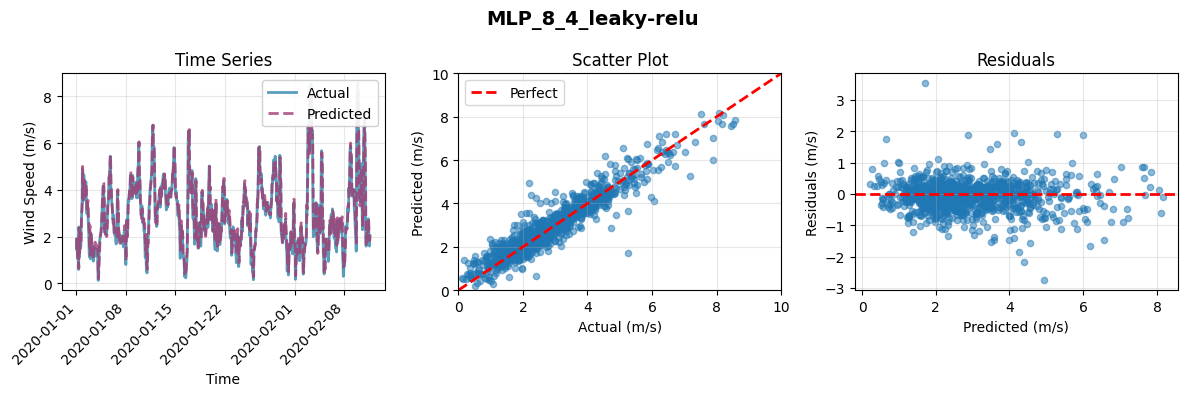


Training MLP_8_4_relu model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

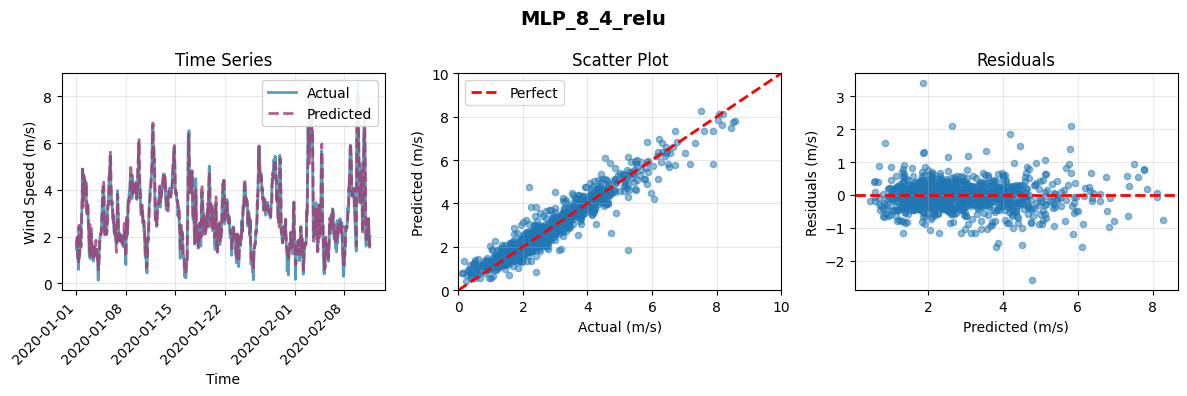


Training MLP_8_4_tanh model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

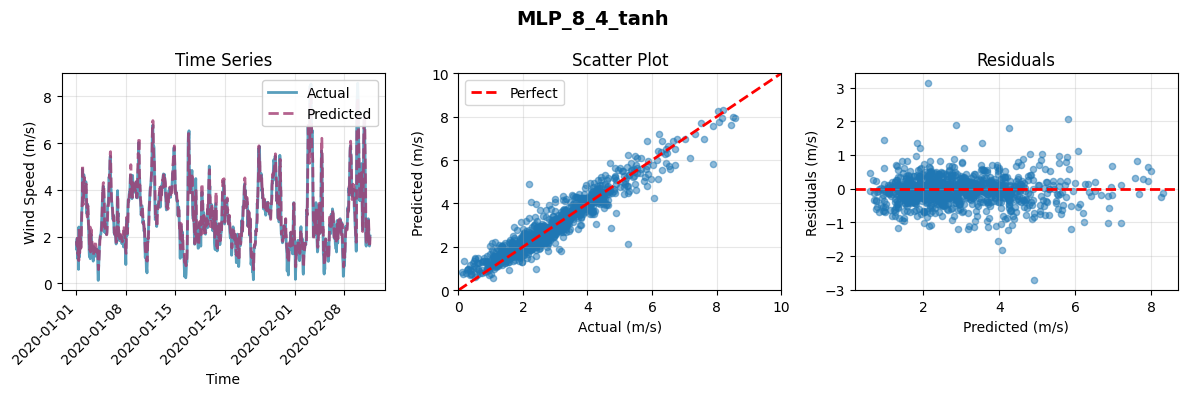


Training MLP_8_4_sigmoid model...
Training MLP on cpu with 274 batches per epoch...


Training MLP:   0%|          | 0/500 [00:00<?, ?epoch/s]

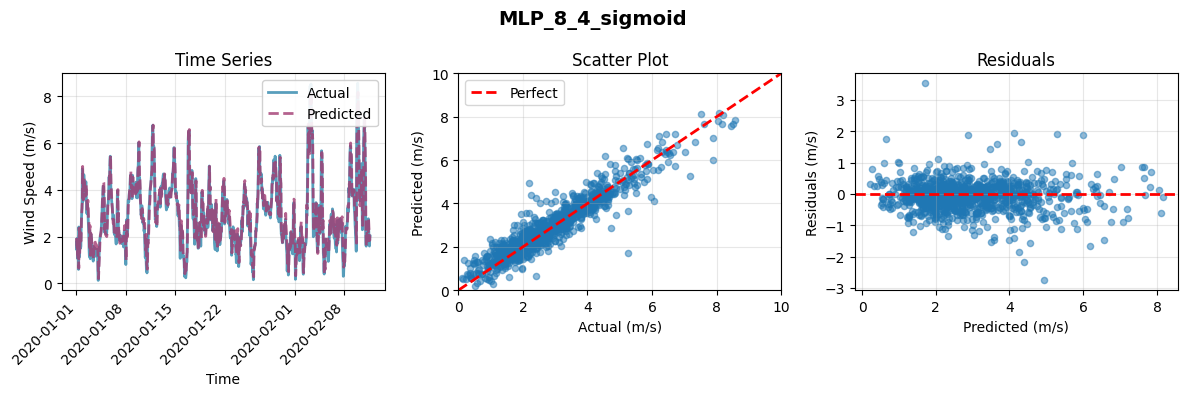


MODEL COMPARISON
             Model  MAE (m/s)  RMSE (m/s)       R²  Asymmetric MSE
      MLP_8_4_tanh   0.256591    0.361472 0.933205        0.173185
      MLP_8_4_relu   0.255064    0.358352 0.934353        0.174268
MLP_8_4_leaky-relu   0.318097    0.447453 0.897650        0.261070
   MLP_8_4_sigmoid   0.318097    0.447453 0.897650        0.261070


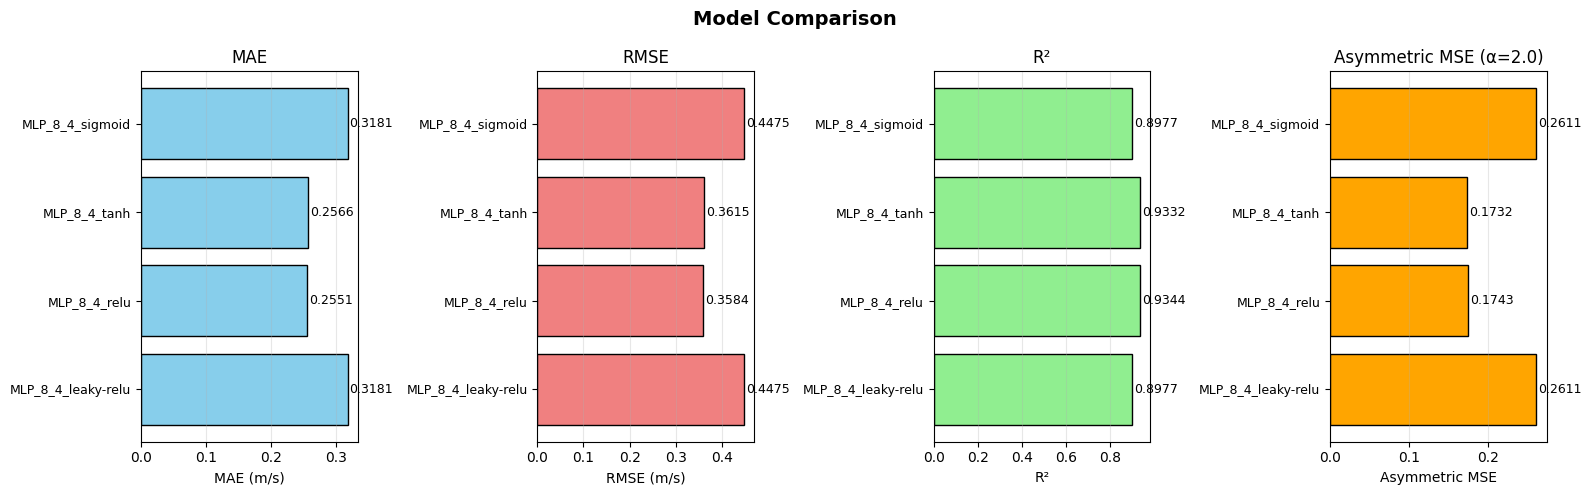

In [11]:
# Collect results from all models
results = []

# Precompute common data views so each model can grab what it needs
DROP_COLS = ['datetime', 'target_next_hour']
X_train_full = train_df.copy()
X_test_full = test_df.copy()
X_train_features = train_df.drop(columns=DROP_COLS).copy()
X_test_features = test_df.drop(columns=DROP_COLS).copy()
y_train = train_df['target_next_hour']
y_test = test_df['target_next_hour']

data_views = {
    'full': (X_train_full, y_train, X_test_full, y_test),
    'features': (X_train_features, y_train, X_test_features, y_test),
}

model_configs = [

    {'name': 'MLP_8_4_leaky-relu',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [8, 4], 'activation': "leaky_relu"}},

    {'name': 'MLP_8_4_relu',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [8, 4], 'activation': 'relu'}},

    {'name': 'MLP_8_4_tanh',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [8, 4], 'activation': "tanh"}},

    {'name': 'MLP_8_4_sigmoid',
     'constructor': MLPModel,
     'data_view': 'features',
     'params': {'hidden_layer_sizes': [8, 4], 'activation': "sigmoid"}},

]

for cfg in model_configs:
    print(f"\nTraining {cfg['name']} model...")
    constructor = cfg['constructor']
    params = cfg.get('params', {})
    model = constructor(**params)

    X_train_sel, y_train_sel, X_test_sel, y_test_sel = data_views[cfg['data_view']]
    result = evaluate(
        model,
        X_train_sel,
        y_train_sel,
        X_test_sel,
        y_test_sel,
        model_name=cfg['name'],
    )
    results.append(result)

    preds = result['predictions']
    y_plot = y_test_sel
    datetime_plot = test_datetime

    if cfg.get('mask_nan_predictions'):
        valid_mask = ~np.isnan(preds)
        if valid_mask.sum() == 0:
            print(f"Skipping plot for {cfg['name']} (all predictions NaN).")
            continue
        preds = preds[valid_mask]
        y_plot = y_plot.iloc[valid_mask] if hasattr(y_plot, 'iloc') else y_plot[valid_mask]
        datetime_plot = (
            test_datetime.iloc[valid_mask]
            if hasattr(test_datetime, 'iloc')
            else test_datetime[valid_mask]
        )

    plot_predictions(y_plot, preds, model_name=cfg['name'], datetime_index=datetime_plot)
    plt.show()



    # Compare all models
scorecard = compare(results, plot=True)